# Predicting Property Maintenance Fines with neural networks

Neural network short version of the same project solved with classical machine learning classifiers [here](https://github.com/angelmtenor/applied-ML-coursera/blob/master/4_property_maintenance_fines.ipynb)



Both versions are based on assignment 4 of [Applied Machine Learning in Python | Coursera](https://www.coursera.org/learn/python-machine-learning)


Goal: Predict the probability that a set of blight tickets will be paid on time

Data provided by Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)), the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) and the City of Detroit [Detroit Open Data Portal](https://data.detroitmi.gov/).
 

Each row of the dataset   corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. 

**Features**
    
    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
** Labels **

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction]
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import helper

# helper.reproducible(seed=0)  # Setup reproducible results from run to run using Keras
sns.set()

Using TensorFlow backend.


##  1. Data Processing

In [2]:
data_path = 'data/property_maintenance_fines_data.csv'
target = ['compliance']

df_original = pd.read_csv(data_path, encoding='iso-8859-1', dtype='unicode')
print("{} rows \n{} columns \ntarget: {}".format(*df_original.shape, target))

250306 rows 
34 columns 
target: ['compliance']


### Explore and Clean the target

In [3]:
print(df_original[target].squeeze().value_counts(dropna=False))

0.0    148283
NaN     90426
1.0     11597
Name: compliance, dtype: int64


In [4]:
# Remove rows with NULL targets

df_original = df_original.dropna(subset=target)

print(df_original[target].squeeze().value_counts())
print(df_original.shape)

0.0    148283
1.0     11597
Name: compliance, dtype: int64
(159880, 34)


** Imbalanced target: the evaluation metric used in this problem is the Area Under the ROC Curve **

###  Split original data into training and validation test set

In [5]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(
    df_original, test_size=0.2, stratify=df_original[target], random_state=0)

** To avoid data leakage, only the training dataframe, df, will be explored and processed here** 

### Show training data

In [6]:
df.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
131030,159232,Department of Public Works,"Montgomery-Coit, Kimberlye","JOHNSON-GREENE, MARGUSIE F.",11645.0,LAKEPOINTE,NaN,11645,LAKEPOINTE,DETROIT,...,0.0,85.0,85.0,0.0,2008-09-12 00:00:00,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0
29573,49039,"Buildings, Safety Engineering & Env Department","Watson, Jerry","BAPT CHURCH, HOLY TABERNACLE",3184.0,CANFIELD,NaN,3184,E. CANFIELD,DETROIT,...,0.0,305.0,305.0,0.0,2007-06-26 00:00:00,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0


#### Missing values

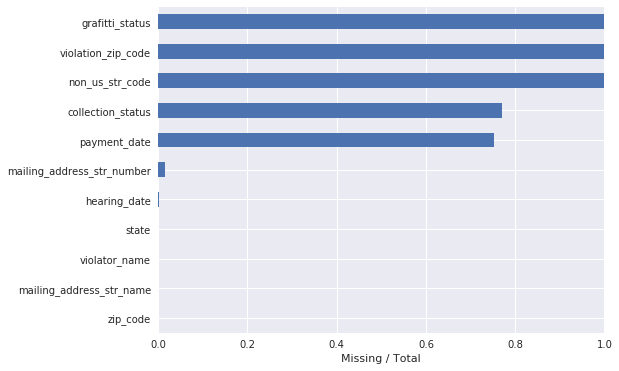

In [7]:
helper.missing(df)

### Transform Data

#### Remove irrelevant features

In [8]:
def remove_features(df):

    relevant_col = ['agency_name', 'violation_street_name', 'city', 'state', 'violator_name',
        'violation_code', 'late_fee', 'discount_amount', 'judgment_amount', 'disposition',
        'fine_amount', 'compliance']

    df = df[relevant_col]

    return df


df = remove_features(df)

print(df.shape)

(127904, 12)


#### Classify features

In [9]:
num = ['late_fee', 'discount_amount', 'judgment_amount', 'fine_amount']

df = helper.classify_data(df, target, numerical=num)
df.dtypes

late_fee                  float32
discount_amount           float32
judgment_amount           float32
fine_amount               float32
agency_name              category
violation_street_name    category
city                     category
state                    category
violator_name            category
violation_code           category
disposition              category
compliance               category
dtype: object

In [10]:
#num = ['late_fee', 'discount_amount', 'judgment_amount', 'fine_amount']  # numerical features
#cat = [col for col in df if col not in num if col not in target]  # categorical features

#### Remove low-frequency categorical values

In [11]:
df = helper.remove_lowfreq(df, target=target, ratio=0.001, show=False)

####  Fill missing values

Missing categorical values filled by 'Other'
There are no numerical missing values

In [12]:
df = helper.fill_simple(df, target, missing_categorical='Other') 


Missing numerical filled with: median
Missing categorical filled with label: "Other"


In [13]:
helper.missing(df);

No missing values found


In [14]:
df.dtypes

late_fee                  float32
discount_amount           float32
judgment_amount           float32
fine_amount               float32
agency_name              category
violation_street_name    category
city                     category
state                    category
violator_name            category
violation_code           category
disposition              category
compliance               category
dtype: object

In [15]:
copy_df = df.copy()  # checkpoint
del(df)

## 2 Neural Network Model

In [16]:
# From now on use data instead of df
data = copy_df.copy()
data.head(2)

,late_fee,discount_amount,judgment_amount,fine_amount,agency_name,violation_street_name,city,state,violator_name,violation_code,disposition,compliance
131030,5.0,0.0,85.0,50.0,Department of Public Works,LAKEPOINTE,DETROIT,MI,Other,9-1-103(C),Responsible by Determination,0.0
29573,25.0,0.0,305.0,250.0,"Buildings, Safety Engineering & Env Department",Other,DETROIT,MI,Other,9-1-36(a),Responsible by Default,0.0


### Scale numerical variables

In [17]:
data, scale_param = helper.scale(data)

### Create dummy features

In [18]:
data, dict_dummies = helper.replace_by_dummies(data, target)

In [19]:
model_features = [f for f in data if f not in target]  # save features order for test set

data.head(3)

,late_fee,discount_amount,judgment_amount,fine_amount,compliance,"agency_name_Buildings, Safety Engineering & Env Department",agency_name_Department of Public Works,agency_name_Detroit Police Department,agency_name_Health Department,agency_name_Other,...,violation_code_9-1-43(a) - (Dwellin,violation_code_9-1-43(a) - (Structu,violation_code_9-1-81(a),violation_code_9-1-82(d) - (Dwellin,violation_code_Other,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination,disposition_Other
131030,-0.422306,-0.049474,-0.451255,-0.453714,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29573,-0.126339,-0.049474,-0.154289,-0.156975,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2657,-0.126339,-0.049474,-0.154289,-0.156975,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Split the data into training and validation sets

In [20]:
def validation_split(data, val_size=0.25):

    train, test = train_test_split(
        data, test_size=val_size, random_state=0, stratify=data[target])

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_val, y_val = test.drop(target, axis=1).values, test[target].values
    # _nc: non-categorical yet (needs one-hot encoding)

    return x_train, y_train, x_val, y_val


x_train, y_train, x_val, y_val = validation_split(data, val_size=0.2)

x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)
X_val = x_val.astype(np.float16)
y_val = y_val.astype(np.float16)

print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("val size \t X:{} \t Y:{}".format(X_val.shape, y_val.shape))

train size 	 X:(102323, 445) 	 Y:(102323, 1)
val size 	 X:(25581, 445) 	 Y:(25581, 1)


In [21]:
def separate_x_y(data):
    """ Separate the data into features and target (x=features, y=target) """

    x, y = data.drop(target, axis=1).values, data[target].values
    x = x.astype(np.float16)
    y = y.astype(np.float16)
   
    return x, y


# x_train, y_train = separate_x_y(data)

In [22]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc


def scores(y_test, y_pred, plot=True):
    """ Print  different scores and plot ROC curve """
    print()
    print('ROC AUC: \t{:.2f}'.format(roc_auc_score(y_test, y_pred)))
    print('F1: \t\t{:.2f}'.format(f1_score(y_test, y_pred)))
    print('Accuracy: \t{:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: \t{:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: \t{:.2f}'.format(recall_score(y_test, y_pred)))
    print('\n Confusion matrix: \n', confusion_matrix(y_test, y_pred))

    if plot:

        fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)
        roc_auc_lr = auc(fpr_lr, tpr_lr)

        plt.figure()
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr_lr, tpr_lr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.axes().set_aspect('equal')

### Dummy classifier

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 4.61 ms

ROC AUC: 	0.50
F1: 		0.00
Accuracy: 	0.93
Precision: 	0.00
Recall: 	0.00

 Confusion matrix: 
 [[23725     0]
 [ 1856     0]]


/home/angel/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/angel/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


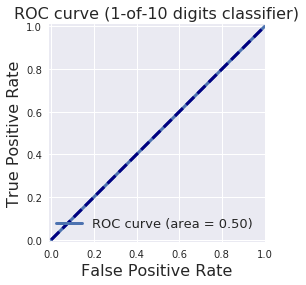

In [23]:
from sklearn.dummy import DummyClassifier

# Negative class (0) is most frequent
%time clf = DummyClassifier(strategy='most_frequent').fit(x_train, np.ravel(y_train))
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_pred = clf.predict(X_val).reshape([-1, 1])

scores(y_val, y_pred)

### Random forest classifier (best of grid search)

In [24]:
from sklearn.ensemble import RandomForestClassifier


%time clf_random_forest_opt = RandomForestClassifier(n_estimators = 30, max_features=150, \
                                max_depth=13, class_weight='balanced', n_jobs=-1, \
                                   random_state=0).fit(x_train, np.ravel(y_train))

CPU times: user 27.2 s, sys: 20 ms, total: 27.2 s
Wall time: 8.01 s


In [25]:
y_train_pred = clf_random_forest_opt.predict(x_train).reshape([-1, 1])
print('Random forest training ROC AUC: \t{:.2f} \n'.format(roc_auc_score(y_train, y_train_pred)))

Random forest training ROC AUC: 	0.76 



### Neural Network classifier

In [26]:
def one_hot_output(y_train, y_val):
    num_classes = len(np.unique(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    return y_train, y_val


y_train, y_val = one_hot_output(y_train, y_val)

In [27]:
from sklearn.utils import class_weight

y_plain = np.ravel(y_train)

cw = class_weight.compute_class_weight('balanced', np.unique(y_plain), y_plain)
cw = {idx : value for idx, value in enumerate(cw)}

In [28]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout


def build_nn(input_size, output_size, summary=False):

    input_nodes = input_size//4

    model = Sequential()
    model.add(
        Dense(
            input_nodes,
            input_dim=input_size))         
    
    model.add(
        Dense(
            output_size,
            activation='softmax'))

    if summary:
        model.summary()

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


model = build_nn(x_train.shape[1], y_train.shape[1], summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 111)               49506     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 224       
Total params: 49,730
Trainable params: 49,730
Non-trainable params: 0
_________________________________________________________________


In [29]:
import os
from time import time
model_path = os.path.join("models", "detroit.h5")


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """ 
    Train the neural network model. If no validation_datais provided, a split for validation
    will be used
    """
    
    if show:
        print('Training ....')
    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=1)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=4096,
        
        class_weight = cw,
        
        verbose=1,
        validation_split=0.3,
        validation_data = validation_data,
        callbacks=callbacks)

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        helper.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)
    
    return history
        

model = None
model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train, path=None, show=None);


y_pred_train = model.predict(x_train, verbose=1)
print('\n\n ROC_AUC train:\t{:.2f} \n'.format(roc_auc_score(y_train, y_pred_train)))

y_pred_val = model.predict(x_val, verbose=1)
print('\n\n ROC_AUC val:\t{:.2f}'.format(roc_auc_score(y_val, y_pred_val)))

Train on 71626 samples, validate on 30697 samples
Epoch 1/100
71626/71626 [==============================] - 1s - loss: 0.3747 - acc: 0.8993 - val_loss: 0.2360 - val_acc: 0.9310
Epoch 2/100
71626/71626 [==============================] - 0s - loss: 0.2244 - acc: 0.9333 - val_loss: 0.2267 - val_acc: 0.9313
Epoch 3/100
71626/71626 [==============================] - 0s - loss: 0.2129 - acc: 0.9341 - val_loss: 0.2172 - val_acc: 0.9320
Epoch 4/100
71626/71626 [==============================] - 0s - loss: 0.2063 - acc: 0.9347 - val_loss: 0.2132 - val_acc: 0.9324
Epoch 5/100
71626/71626 [==============================] - 0s - loss: 0.2029 - acc: 0.9349 - val_loss: 0.2115 - val_acc: 0.9328
Epoch 6/100
71626/71626 [==============================] - 0s - loss: 0.2014 - acc: 0.9357 - val_loss: 0.2111 - val_acc: 0.9333
Epoch 7/100
71626/71626 [==============================] - 0s - loss: 0.2006 - acc: 0.9360 - val_loss: 0.2111 - val_acc: 0.9339
Epoch 8/100
71626/71626 [=============================

## Validation Test set

In [30]:
df_test.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
29156,48696,Department of Public Works,"Funchess, Mitchell","CORP, CONTIMORTGAGE",8200.0,HEYDEN,NaN,3815,WEST TEMPLE,SALT LAKE CITY,...,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,IN COLLECTION,NaN,non-compliant by no payment,0.0
125262,152329,"Buildings, Safety Engineering & Env Department","Doetsch, James","JACKSON, THEO",13821.0,GLENWOOD,NaN,1464,PO BOX,DETROIT,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0


#### Process validation test data with training parameters (no data leakage)

In [31]:
df_test = remove_features(df_test)

In [32]:
df_test = helper.classify_data(df_test, target, numerical=num)

In [33]:
df_test = helper.remove_lowfreq(df_test, target=target, ratio=0.001, show=False)

In [34]:
df_test = helper.fill_simple(df_test, target, missing_categorical='Other') 

Missing numerical filled with: median
Missing categorical filled with label: "Other"


In [35]:
df_test, _ = helper.scale(df_test, scale_param)
df_test, _ = helper.replace_by_dummies(df_test, target, dict_dummies)

In [36]:
df_test = df_test[model_features+target] # sort columns to match training features order

In [37]:
x_test, y_test = separate_x_y(df_test)

#### Validation test accuracies

In [38]:
y_pred = clf_random_forest_opt.predict(x_test).reshape([-1, 1])
print('Random forest ROC AUC test: \t{:.2f} \n'.format(roc_auc_score(y_test, y_pred)))

Random forest ROC AUC test: 	0.74 



In [39]:
y_pred = model.predict(x_test, verbose=1)
print('\n Neural Network ROC AUC test: \t{:.2f} \n'.format( roc_auc_score(y_test, y_pred[:,1])))

31840/31976 [============================>.] - ETA: 0s
 Neural Network ROC AUC test: 	0.80 

